In [1]:
%pylab inline

from __future__ import division
from time import strftime
from calendar import monthrange
from datetime import datetime, date, timedelta
print strftime('%Y-%m-%d %X'), 'clock set'
import random
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

Populating the interactive namespace from numpy and matplotlib
2015-05-27 17:56:51 clock set


In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
X_test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]
print train.shape, X_test.shape

(10506, 12) (116293, 10)


In [3]:
X_given = train[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]
y_given = train['WnvPresent']

msk = np.random.rand(len(X_given)) < 0.8
X_train, X_validate, y_train, y_validate = X_given[msk], X_given[~msk], y_given[msk], y_given[~msk]

print X_train.shape, X_validate.shape, y_train.shape, y_validate.shape

(8400, 10) (2106, 10) (8400,) (2106,)


In [4]:
X_train.loc[:, 'Year'] = [i.year for i in X_train.loc[:, 'Date']]
X_validate.loc[:, 'Year'] = [i.year for i in X_validate.loc[:, 'Date']]

X_train.loc[:, 'Week'] = [i.week for i in X_train.loc[:, 'Date']]
X_validate.loc[:, 'Week'] = [i.week for i in X_validate.loc[:, 'Date']]

X_train.loc[:, 'Day'] = [i.timetuple().tm_yday for i in X_train.loc[:, 'Date']]
X_validate.loc[:, 'Day'] = [i.timetuple().tm_yday for i in X_validate.loc[:, 'Date']]

/Library/Python/2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


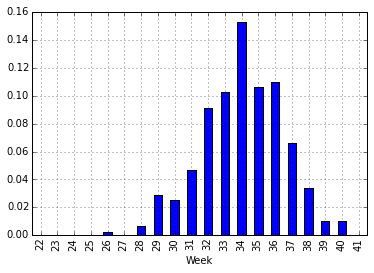

In [5]:
probaByWeek = pd.concat([X_train, y_train], axis=1).groupby('Week')['WnvPresent'].mean()
probaByWeek.plot(kind='bar')

AUC: 0.797139704811
[ 1.15284553  0.15284553  0.11014493  0.10653753  0.10248447  0.09090909
  0.06593407  0.04684318  0.03364486  0.02886598  0.02533784  0.01038961
  0.01015228  0.00632111  0.00253165  0.        ]


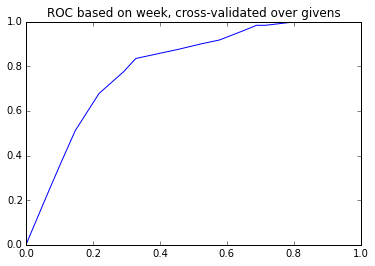

In [6]:
z = [probaByWeek[i.week] for i in X_validate.ix[:, 'Date']]
fpr, tpr, thresholds = roc_curve(y_validate, z)
print 'AUC:', auc(fpr, tpr)
print thresholds
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC based on week, cross-validated over givens')
plt.plot(fpr, tpr)

In [9]:
proba2007 = pd.concat([X_train.ix[X_train['Year']==2007], y_train.ix[X_train['Year']==2007]], axis=1).groupby('Week')['WnvPresent'].mean()
proba2009 = pd.concat([X_train.ix[X_train['Year']==2009], y_train.ix[X_train['Year']==2009]], axis=1).groupby('Week')['WnvPresent'].mean()
proba2011 = pd.concat([X_train.ix[X_train['Year']==2011], y_train.ix[X_train['Year']==2011]], axis=1).groupby('Week')['WnvPresent'].mean()
proba2013 = pd.concat([X_train.ix[X_train['Year']==2013], y_train.ix[X_train['Year']==2013]], axis=1).groupby('Week')['WnvPresent'].mean()

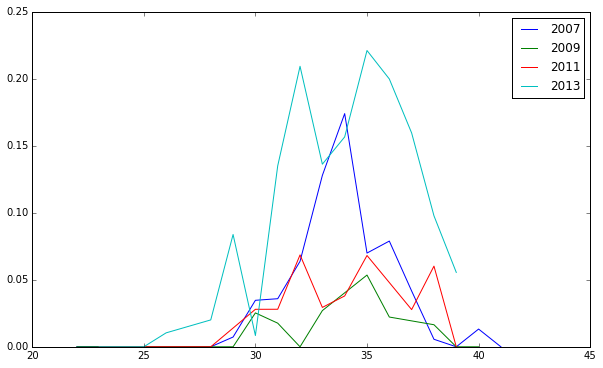

In [10]:
plt.figure(figsize=(10,6))
plt.plot(proba2007.index, proba2007, label='2007')
plt.plot(proba2009.index, proba2009, label='2009')
plt.plot(proba2011.index, proba2011, label='2011')
plt.plot(proba2013.index, proba2013, label='2013')
plt.legend()